# Exploring different numerical schemes

In [7]:
# Cell 1: common imports & exact solution
import numpy as np
import matplotlib.pyplot as plt
import time

a  = 1.0        # advection speed
nx = 200        # grid points
T  = 1.0        # final time
x  = np.linspace(0,1,nx,endpoint=False)
def exact(a,T,x):
    return np.exp(-(((x - a*T)%1 - 0.25)/0.05)**2)
    
t_ex = np.linspace(0,T,500)
u_ex = exact(a,T,t_ex)
CFLs = [0.8, 1.2]


/Users/fredericstrand/Documents/sommer-2024-ML-projects/myenv/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


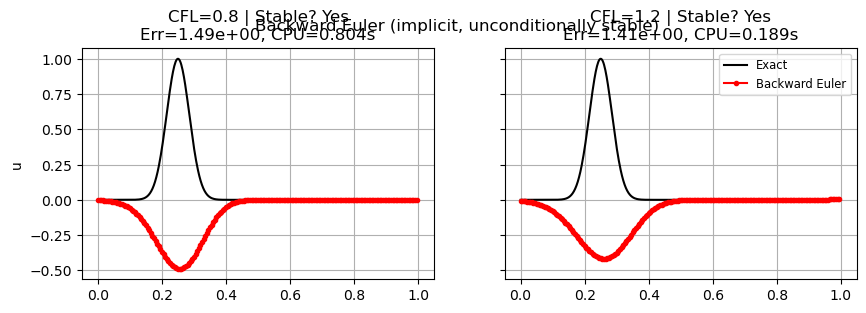

In [20]:
# Cell 7: Backward Euler (implicit)
def backward_euler(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    # Precompute matrix solve constants for u_t + a u_x=0 with centered flux:
    ν = a*dt/(2*dx)
    # Tridiagonal:  u_j - ν*(u_{j+1}-u_{j-1}) = RHS
    from scipy.sparse import diags
    N = nx
    main = np.ones(N)
    off  = np.full(N-1, -ν)
    data = [off, main, ν*+np.zeros(N-1)]  # careful with signs
    A    = diags([ν, main, -ν],[ -1,0,1 ], shape=(N,N)).tocsc()
    # periodic:
    A[0,-1] = -ν; A[-1,0] = ν

    u = np.exp(-((x-0.25)/0.05)**2)
    for _ in range(nt):
        rhs = u.copy()
        u = np.linalg.solve(A.toarray(), rhs)
    return u

fig,axes = plt.subplots(1,2,figsize=(10,3),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=backward_euler(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'k-',label='Exact')
    ax.plot(x,u,'r.-',label='Backward Euler')
    ax.set_title(f'CFL={cfl:.1f} | Stable? Yes\nErr={err:.2e}, CPU={cpu:.3f}s')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.suptitle('Backward Euler (implicit, unconditionally stable)')
plt.show()


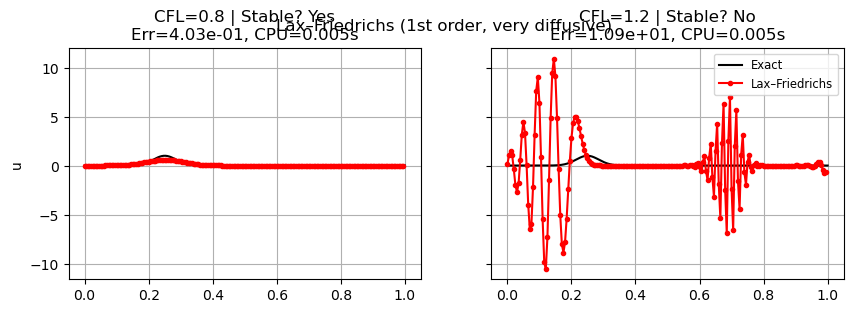

In [21]:
# Cell 8: Lax–Friedrichs
def lax_friedrichs(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    ν = a*dt/dx
    for _ in range(nt):
        ul,ur = np.roll(u,1), np.roll(u,-1)
        u = 0.5*(ul+ur) - 0.5*ν*(ur-ul)
    return u

fig,axes = plt.subplots(1,2,figsize=(10,3),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=lax_friedrichs(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ok = 'Yes' if cfl<=1 else 'No'
    ax.plot(t_ex,u_ex,'k-',label='Exact')
    ax.plot(x,u,'r.-',label='Lax–Friedrichs')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {ok}\nErr={err:.2e}, CPU={cpu:.3f}s')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.suptitle('Lax–Friedrichs (1st order, very diffusive)')
plt.show()


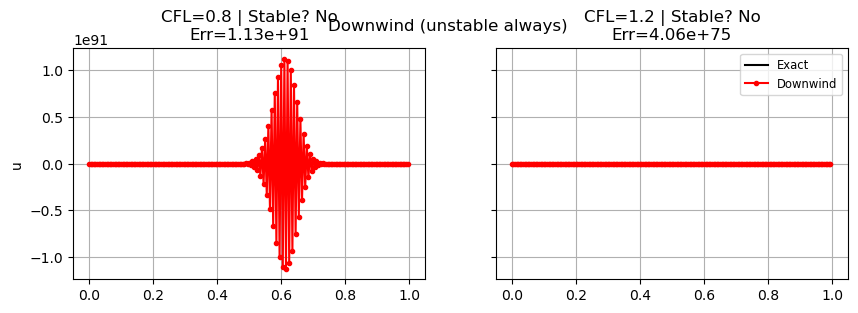

In [11]:
# Cell 3: Downwind
def downwind(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    for _ in range(nt):
        un = u.copy(); ν=a*dt/dx
        if a>0:
            u = un - ν*(np.roll(un,-1) - un)
        else:
            u = un - ν*(un - np.roll(un,1))
    return u

fig,axes = plt.subplots(1,2,figsize=(10,3),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=downwind(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'k-',label='Exact')
    ax.plot(x,u,'r.-',label='Downwind')
    ax.set_title(f'CFL={cfl:.1f} | Stable? No\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.suptitle('Downwind (unstable always)')
plt.show()


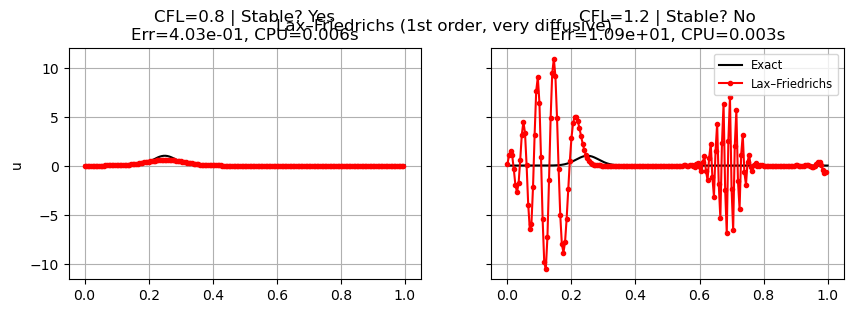

In [22]:
# Cell 8: Lax–Friedrichs
def lax_friedrichs(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    ν = a*dt/dx
    for _ in range(nt):
        ul,ur = np.roll(u,1), np.roll(u,-1)
        u = 0.5*(ul+ur) - 0.5*ν*(ur-ul)
    return u

fig,axes = plt.subplots(1,2,figsize=(10,3),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=lax_friedrichs(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ok = 'Yes' if cfl<=1 else 'No'
    ax.plot(t_ex,u_ex,'k-',label='Exact')
    ax.plot(x,u,'r.-',label='Lax–Friedrichs')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {ok}\nErr={err:.2e}, CPU={cpu:.3f}s')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.suptitle('Lax–Friedrichs (1st order, very diffusive)')
plt.show()


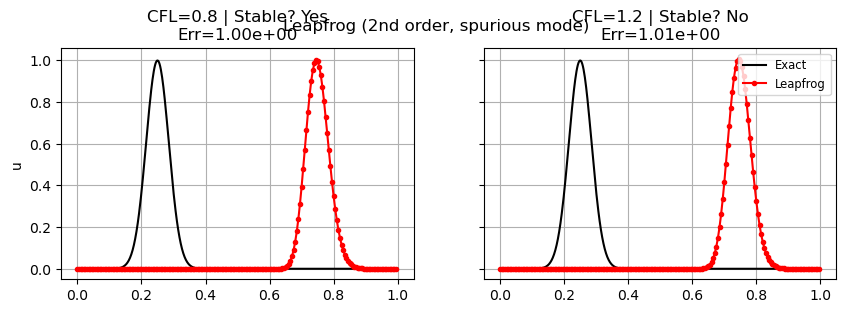

In [12]:
# Cell 4: Leapfrog
def leapfrog(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u_nm1 = np.exp(-((x-0.25)/0.05)**2)
    # starter: upwind
    ν = a*dt/dx
    u_n = u_nm1 - ν*(u_nm1 - np.roll(u_nm1,1))
    for _ in range(1,nt):
        u_np1 = u_nm1 - 0.5*ν*(np.roll(u_n,-1) - np.roll(u_n,1))
        u_nm1,u_n = u_n,u_np1
    return u_n

fig,axes = plt.subplots(1,2,figsize=(16,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=leapfrog(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'k-',label='Exact')
    ax.plot(x,u,'r.-',label='Leapfrog')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {"Yes" if cfl<=1 else "No"}\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.suptitle('Leapfrog (2nd order, spurious mode)')
plt.show()


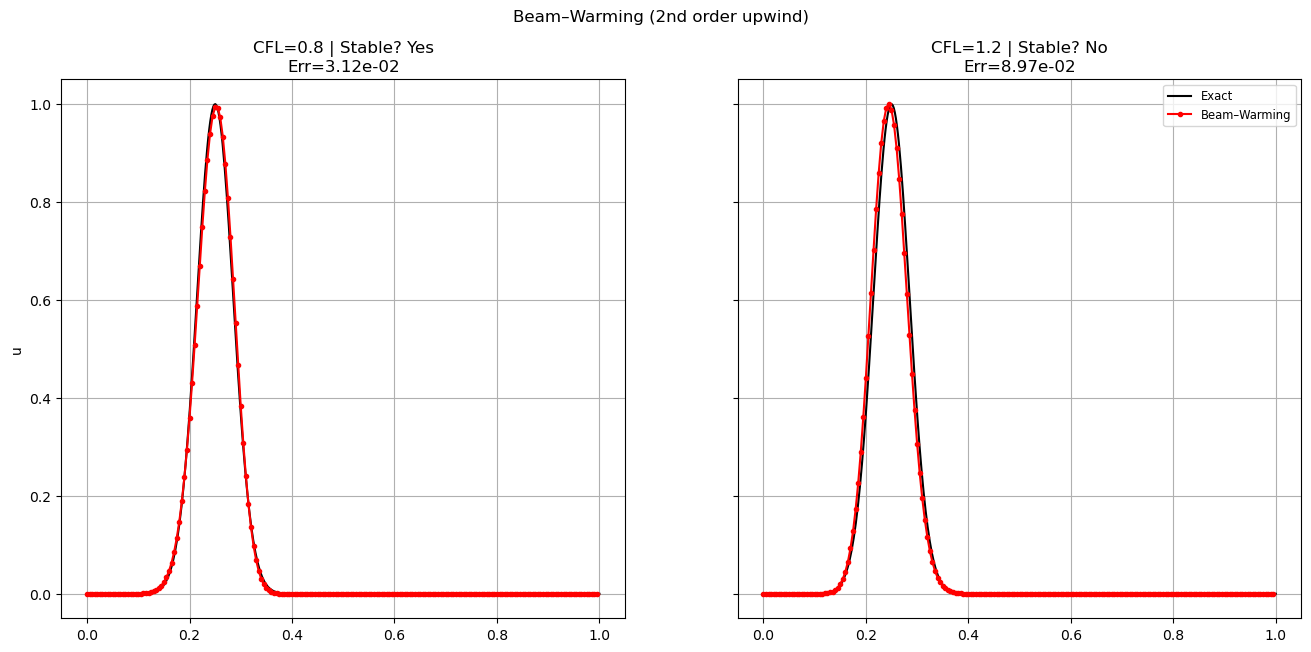

In [19]:
# Cell 6: Beam–Warming
def beam_warming(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u_prev = np.exp(-((x-0.25)/0.05)**2)
    ν = a*dt/dx
    # start with upwind
    u = u_prev - ν*(u_prev - np.roll(u_prev,1))
    for _ in range(1,nt):
        ul1, ul2, ul3 = u, np.roll(u,1), np.roll(u,2)
        u_new = (u 
                 - 0.5*ν*(3*u - 4*ul2 + ul3)
                 + 0.5*ν*ν*(u - 2*ul2 + ul3))
        u_prev, u = u, u_new
    return u

fig,axes = plt.subplots(1,2,figsize=(16,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=beam_warming(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'k-',label='Exact')
    ax.plot(x,u,'r.-',label='Beam–Warming')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {"Yes" if cfl<=1 else "No"}\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.suptitle('Beam–Warming (2nd order upwind)')
plt.show()
